## Preface



If need be&#x2026;



In [1]:
#!pip install -r requirements.txt

## Introduction



Here we give a set of generic instructions for analyzing demand for
food and nutrition.  Inputs include a datasets of consumption
quantities, consumption expenditures, household characteristics, and a
food conversion table.

The different datasets should be indexed as follows:

| Dataset|Indexed by|Columns|
|---|---|---|
| Expenditures|j,t,m|i|
| Consumption|j,t,m,u|i|
| HH Characteristics|j,t,m|k|
| FCT|i,u|n|
| RDI|n|k|

where `j` indexes households, `t` indexes periods, `m` indexes
markets, `i` indexes goods, `k` indexes different kinds of household
characteristics, `u` indexes different unit names, and `n` indexes
different nutrients.  Finally, any RDI (&ldquo;recommended daily intake&rdquo;)
tables should be indexed by nutrients, with columns corresponding to
characteristics of persons within the household (e.g., age & sex
categories).

Note that some countries have more than one dataframe of consumption,
distinguished by source; for example Malawi has consumption items
purchased as well as consumption items produced.  Here we focus on
consumption purchases, since one of our immediate aims is to infer
prices paid.



## Step 1: Acquire DataFrames



Here are addresses of google sheets for different dataframes for the
case of Niger:



In [2]:
InputFiles = {'Expenditures':('1ySP8lrXlQ2ChaMdz0HQY85Md65cRRKOZgz-T0zBN2K0','Expenditures'),
              'Consumption':('1kr2NI57xiTQm20A_68NEcLKihVTJw2ZgWCwV98ZD4JE','Consumption'),
              'HH Characteristics':('1ySP8lrXlQ2ChaMdz0HQY85Md65cRRKOZgz-T0zBN2K0','HH Characteristics'),
              'FCT':('1TM7FpKURXFAuXW4dLpGt98QA2CH4WTDty-4nPOUv1Mg','05 NV_sum_57 (per 100g EP)')}

Note that the food items for the FCT for Niger are **not** yet matched
up (&ldquo;harmonized&rdquo;) with food labels indexed by `i` in the expenditure
and consumption datasets.



In [3]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in x.columns:
    x['m'] = 1

x = x.set_index(['j','t','m'])
x.columns.name = 'i'

x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)

# Get HH characteristics...
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['j','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get purchased consumption quantities
q = get_clean_sheet(InputFiles['Consumption'][0],
                    sheet=InputFiles['Consumption'][1])

if 'm' not in q.columns:
    q['m'] = 1

q = q.set_index(['j','t','m','u'])
q.columns.name = 'i'

q = q.apply(lambda x: pd.to_numeric(x,errors='coerce'))
q = q.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

#### This bit peculiar to Niger FCT #####
fct = fct.loc[fct.Code.str.len()==6]
fct = fct.set_index('Code')
fct.columns = [v.replace('\n',' ') for v in fct.columns]
########################################

fct.index.name = 'i'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


## Step 2: Estimate Demand System



Here, use data on log *expenditures* and household characteristics to
create a CFEDemand `result`.



In [4]:
import cfe

result = cfe.Result(y=np.log(x),z=z)

# Estimates most things (not counting std errors for betas).
xhat = result.get_predicted_expenditures() 

result.get_beta(as_df=True).sort_values(ascending=False) # Check sanity...

Missing dependencies for OracleDemands.


i
Dates            0.702957
Biscuit          0.676033
Fresh fish       0.671965
Other citrus     0.671292
Cassava tuber    0.647659
                   ...   
Squash           0.227300
Salt             0.193599
Cornstarch       0.162035
Corn             0.101450
Millet           0.097319
Name: beta, Length: 61, dtype: float64

## Step 3: Infer prices



Next, we divide predicted expenditures by actual quantities to get
prices, then choose prices corresponding to some units (e.g.,
kilograms) we can map into the  FCT.



In [5]:
# xhat is an xarray; change to df
xhatdf = xhat.to_dataset('i').to_dataframe()
xhatdf.columns.name ='i'

phat = xhatdf/q
phat

i                     796  Alcoholic beverages  \
j      t    m u                                  
101    2011 1 kg      NaN                  NaN   
       2014 1 NaN     NaN                  NaN   
102    2011 1 gramme  NaN                  NaN   
              kg      NaN                  NaN   
              litre   NaN                  NaN   
...                   ...                  ...   
269012 2014 1 NaN     NaN                  NaN   
270011 2011 1 NaN     NaN                  NaN   
       2014 1 NaN     NaN                  NaN   
270012 2011 1 NaN     NaN                  NaN   
       2014 1 NaN     NaN                  NaN   

i                     Alcoholic beverages taken out of home  \
j      t    m u                                               
101    2011 1 kg                                        NaN   
       2014 1 NaN                                       NaN   
102    2011 1 gramme                                    NaN   
              kg                                        NaN   
              litre                                     NaN   
...                                                     ...   
269012 2014 1 NaN                                       NaN   
270011 2011 1 NaN                                       NaN   
       2014 1 NaN                                       NaN   
270012 2011 1 NaN                                       NaN   
       2014 1 NaN                                       NaN   

i                     Bambara groundnut  Baobab leaves  Bean fritters  Beans  \
j      t    m u                                                                
101    2011 1 kg                    NaN            NaN            NaN    NaN   
       2014 1 NaN                   NaN            NaN            NaN    NaN   
102    2011 1 gramme                NaN            NaN            NaN    NaN   
              kg                    NaN            NaN            NaN    NaN   
              litre                 NaN            NaN            NaN    NaN   
...                                 ...            ...            ...    ...   
269012 2014 1 NaN                   NaN            NaN            NaN    NaN   
270011 2011 1 NaN                   NaN            NaN            NaN    NaN   
       2014 1 NaN                   NaN            NaN            NaN    NaN   
270012 2011 1 NaN                   NaN            NaN            NaN    NaN   
       2014 1 NaN                   NaN            NaN            NaN    NaN   

i                            Beef  Biscuit  Boiled beans  ...  Sweet potato  \
j      t    m u                                           ...                 
101    2011 1 kg              NaN      NaN           NaN  ...           NaN   
       2014 1 NaN             NaN      NaN           NaN  ...           NaN   
102    2011 1 gramme          NaN      NaN           NaN  ...           NaN   
              kg      2983.254264      NaN           NaN  ...           NaN   
              litre           NaN      NaN           NaN  ...           NaN   
...                           ...      ...           ...  ...           ...   
269012 2014 1 NaN             NaN      NaN           NaN  ...           NaN   
270011 2011 1 NaN             NaN      NaN           NaN  ...           NaN   
       2014 1 NaN             NaN      NaN           NaN  ...           NaN   
270012 2011 1 NaN             NaN      NaN           NaN  ...           NaN   
       2014 1 NaN             NaN      NaN           NaN  ...           NaN   

i                     Taro and cocoyam  Tea bag  Tea hot drink  Tomato paste  \
j      t    m u                                                                
101    2011 1 kg                   NaN      NaN            NaN           NaN   
       2014 1 NaN                  NaN      NaN            NaN           NaN   
102    2011 1 gramme               NaN      NaN            NaN           NaN   
              kg                   NaN      NaN            N

Note that `phat` gives prices for different *quantities*.  If prices
differ **only** because of quantities (e.g., one deciliter costs one
tenth as much as a liter), then we can use these differences in prices
to convert between different units, even if the units (e.g., &ldquo;basket&rdquo;)
is otherwise unclear.  

If we have enough data on purchases in kilograms, just keep those
prices (otherwise choose some other useful unit).  We also assume
prices are the same for everyone, so just take median.



In [6]:
# Keep kgs
phat = phat.xs('kg',level='u').groupby(['t','m']).median().T.dropna(how='all')

Keep prices in result&#x2026;



In [7]:
result['prices'] = phat.stack().to_xarray().to_array()

# Make this persistent...
result.to_dataset('./foo.ds')

<xarray.Dataset>
Dimensions:           (j: 5343, t: 2, m: 1, i: 61, k: 14, kp: 14, variable: 1)
Coordinates:
  * j                 (j) int64 101 102 103 104 ... 269011 269012 270011 270012
  * t                 (t) int64 2011 2014
  * m                 (m) int64 1
  * i                 (i) object 'Baobab leaves' 'Bean fritters' ... 'Yogurt'
  * k                 (k) <U7 'M 0-3' 'M 4-8' 'M 9-13' ... 'F 31-50' 'F 51+'
  * kp                (kp) <U7 'M 0-3' 'M 4-8' 'M 9-13' ... 'F 31-50' 'F 51+'
  * variable          (variable) int64 2011
Data variables: (12/20)
    alpha             object None
    beta              (i) float64 0.3128 0.3058 0.3504 ... 0.2986 0.3943 0.3704
    delta             (k, i) float64 0.01672 0.02326 0.08354 ... 0.02756 -0.0283
    prices            (variable, i, m) float64 126.8 nan 398.4 ... nan 1.084e+03
    characteristics   (k, j, t, m) float64 0.0 0.0 1.0 1.0 ... nan 0.0 nan 0.0
    loglambdas        (j, t, m) float64 -0.1241 -0.4149 -1.504 ... nan nan 1.523
    ...                ...
    se_beta           object None
    se_alpha          object None
    se_a              (i, t, m) float64 0.02353 0.02547 ... 0.02872 0.03655
    y                 (i, j, t, m) float64 nan nan 6.215 nan ... nan nan nan nan
    logp              object None
    z                 (k, j, t, m) float64 0.0 0.0 1.0 1.0 ... nan 0.0 nan 0.0

## Step 4: Predicting Positive Consumption



An issue with our assessment of fit is that we *predicted* that every
household would consume positive quantitites of every good, and in
making our assessment we ignored the (many) cases in which in fact the
household had zero expenditures on that good.  

Here we&rsquo;re going to go back and use similar framework to try and
estimate the probability with which we&rsquo;ll observe zero expenditures
as a function of &lambda;, prices, and household characteristics.



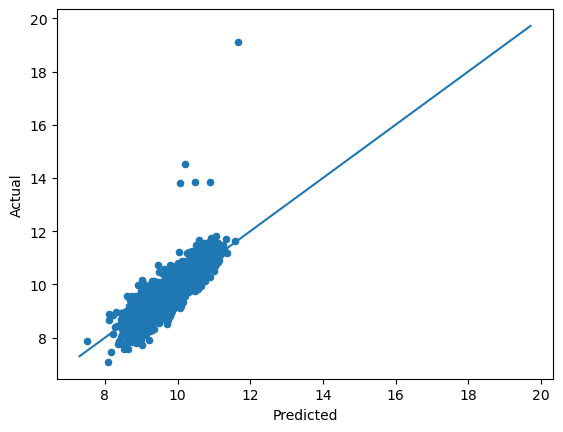

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import cfe

result = cfe.from_dataset('foo.ds')  # Get persistent result saved above...

zeros_r = cfe.Result(y=(0.+(np.exp(result.y)>0)),z=result.z)
weights = zeros_r.get_predicted_log_expenditures()

# Truncate to make weights live in [0,1]
weights = weights.where((weights<1) + np.isnan(weights),1).where((weights>0) + np.isnan(weights),0)

xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()

# Calculate *expected* predicted expenditures, to make unconditional on being positive
xhat = (weights*result.get_predicted_expenditures())
xsum = xhat.sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual':np.log(xbar),'Predicted':np.log(xsum)})

df.plot.scatter(x='Predicted',y='Actual')

# Add 45 degree line
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax])

## Step 5: Get predicted quantities



Now divide predicted expenditures by predicted prices to get predicted
quantities, and put back into a dataframe.



In [9]:
xhatdf = xhat.to_dataset('i').to_dataframe()
xhatdf.columns.name ='i'

qhat = xhatdf.div(phat.T,axis=1)

qhat

i              Baobab leaves  Bean fritters     Beans      Beef  Biscuit  \
t    m j                                                                   
2011 1 101          0.711290            NaN  0.648212  0.804204      NaN   
       102          0.965298            NaN  1.068173  1.582815      NaN   
       103          0.732440            NaN  0.757757  0.382192      NaN   
       104          0.940438            NaN  1.026865  1.141983      NaN   
       105          0.636660            NaN  0.672590  1.116241      NaN   
...                      ...            ...       ...       ...      ...   
2014 1 269010            NaN            NaN       NaN       NaN      NaN   
       269011            NaN            NaN       NaN       NaN      NaN   
       269012            NaN            NaN       NaN       NaN      NaN   
       270011            NaN            NaN       NaN       NaN      NaN   
       270012            NaN            NaN       NaN       NaN      NaN   

i              Bowl of millet with milk  Bowl of millet without milk  \
t    m j                                                               
2011 1 101                          NaN                          NaN   
       102                          NaN                          NaN   
       103                          NaN                          NaN   
       104                          NaN                          NaN   
       105                          NaN                          NaN   
...                                 ...                          ...   
2014 1 269010                       NaN                          NaN   
       269011                       NaN                          NaN   
       269012                       NaN                          NaN   
       270011                       NaN                          NaN   
       270012                       NaN                          NaN   

i                 Bread     Cakes  Cassava tuber  ...    Squash     Sugar  \
t    m j                                          ...                       
2011 1 101     2.548526  0.528514       0.243141  ...  0.506388  1.027795   
       102     3.843271  1.002724       0.661776  ...  0.545834  1.995973   
       103     1.279376  0.511362       0.403935  ...  0.414642  0.890907   
       104     3.253862  0.896648       0.495700  ...  0.558210  1.636894   
       105     2.929345  0.549830       0.268727  ...  0.485982  1.118177   
...                 ...       ...            ...  ...       ...       ...   
2014 1 269010       NaN       NaN            NaN  ...       NaN       NaN   
       269011       NaN       NaN            NaN  ...       NaN       NaN   
       269012       NaN       NaN            NaN  ...       NaN       NaN   
       270011       NaN       NaN            NaN  ...       NaN       NaN   
       270012       NaN       NaN            NaN  ...       NaN       NaN   

i              Sugar cane  Sweet banana  Sweet potato   Tea bag  Tomato paste  \
t    m j                                                                        
2011 1 101       0.041622      0.178365      0.261829  0.218190           NaN   
       102       0.116532      0.328463      0.497788  0.415683           NaN   
       103       0.067139      0.047719      0.268953  0.258516           NaN   
       104       0.103339      0.254886      0.375193  0.397693           NaN   
       105       0.044487      0.260328      0.220882  0.267122           NaN   
...                   ...           ...           ...       ...           ...   
2014 1 269010         NaN           NaN           NaN       NaN           NaN   
       269011         NaN           NaN           NaN       NaN           NaN   
       269012         NaN           NaN           NaN       NaN           NaN   
       270011         NaN           NaN           NaN       NaN           NaN   
       270012         NaN           NaN           NaN       NaN           NaN   

i              Yam

## Step 6: Map predicted quantities into nutrients



May need some work to clean up the FCT, and create food names/indices
corresponding to the `i` index in `qhat`.



In [10]:
print(pd.Series(xhat.coords['i']).to_markdown())

|    | 0                           |
|---:|:----------------------------|
|  0 | Baobab leaves               |
|  1 | Bean fritters               |
|  2 | Beans                       |
|  3 | Beef                        |
|  4 | Biscuit                     |
|  5 | Bowl of millet with milk    |
|  6 | Bowl of millet without milk |
|  7 | Bread                       |
|  8 | Cakes                       |
|  9 | Cassava tuber               |
| 10 | Cigarette                   |
| 11 | Coffee in cans              |
| 12 | Cola nut                    |
| 13 | Corn                        |
| 14 | Corn fritters               |
| 15 | Cornstarch                  |
| 16 | Curd                        |
| 17 | Dates                       |
| 18 | Dry okra                    |
| 19 | Eggs                        |
| 20 | Fresh Okra                  |
| 21 | Fresh Onion                 |
| 22 | Fresh fish                  |
| 23 | Fresh pepper                |
| 24 | Fresh tomato                |
|

| Niger Labels|WAFCT Codes|
|---|---|
| Baobab leaves|04<sub>001</sub>|
| Bean fritters|03<sub>054</sub>|
| Beans|03<sub>022</sub>|
| Beef|07<sub>014</sub>|
| Biscuit|01<sub>188</sub>|
| Bowl of millet with milk|01<sub>174</sub>|
| Bowl of millet without milk|01<sub>167</sub>|
| Bread|01<sub>047</sub>|
| Cakes|01<sub>187</sub>|
| Cassava tuber|02<sub>021</sub>|
| Cigarette||
| Coffee in cans|12<sub>009</sub>|
| Cola nut|06<sub>018</sub>|
| Corn|04<sub>109</sub>|
| Corn fritters|01<sub>123</sub>|
| Cornstarch||
| Curd|10<sub>028</sub>|
| Dates|05<sub>031</sub>|
| Dry okra|04<sub>077</sub>|
| Eggs|08<sub>001</sub>|
| Fresh Okra|04<sub>017</sub>|
| Fresh Onion|04<sub>018</sub>|
| Fresh fish|09<sub>060</sub>|
| Fresh pepper|04<sub>049</sub>|
| Fresh tomato|04<sub>021</sub>|
| Fruit juice|12<sub>013</sub>|
| Goat meat|07<sub>069</sub>|
| Groundnut cake|03<sub>012</sub>|
| Juice powder||
| Maggi cube||
| Malahya||
| Millet|01<sub>095</sub>|
| Mutton|07<sub>004</sub>|
| Orange|05<sub>016</sub>|
| Other citrus||
| Other spices||
| Palm oil|11<sub>007</sub>|
| Pasta|01<sub>077</sub>|
| Peanut butter|06<sub>023</sub>|
| Peanut oil|11<sub>003</sub>|
| Pimento||
| Potato|02<sub>009</sub>|
| Poultry|08<sub>010</sub>|
| Powdered milk|10<sub>002</sub>|
| Rice|01<sub>065</sub>|
| Rice &amp;tomato sauce||
| Rice cowpea|03<sub>143</sub>|
| Salad||
| Salt|13<sub>015</sub>|
| Soft Drinks|12<sub>024</sub>|
| Soumbala|03<sub>042</sub>|
| Squash|04<sub>051</sub>|
| Sugar|13<sub>002</sub>|
| Sugar cane||
| Sweet banana|05<sub>048</sub>|
| Sweet potato|02<sub>049</sub>|
| Tea bag|12<sub>008</sub>|
| Tomato paste|04<sub>066</sub>|
| Yam tuber|02<sub>019</sub>|
| Yodo||
| Yogurt|10<sub>005</sub>|

These particular clean-ups are peculiar to the West African FCT.



In [11]:
# Dictionary mapping index i to fct codes
i_to_fct = pd.read_csv('niger_fct_codes.csv').dropna().set_index('Niger Labels').squeeze().to_dict()

# Create version of qhat with fct ids for labels
myq = qhat.rename(columns=i_to_fct)
use_columns = myq.columns.intersection(i_to_fct.values())
myq = myq[use_columns]

# Drop goods with no obs, households with no goods
myq = myq.dropna(how='all',axis=1).dropna(how='all')

# Create version of fct with just foods in myq
myfct=fct.loc[myq.columns].iloc[:,8:] # Drop columns which aren't nutrients

Before this will work, need columns of qhat to match columns of fct.



In [12]:
nutrients = myq@myfct
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household.

Energy (kcal)                                                                                                               8836.678105
Water (g)                                                                                                                    951.492712
Protein, total (g)                                                                                                           283.964921
Fat, total or [fat, derived by analysis using continuous extraction] (g)                                                            NaN
Carbohydrate, available; calculated by difference (g)                                                                       1181.907371
Fibre, total dietary or [fibre, crude] (g)                                                                                   308.771840
Alcohol (g)                                                                                                                    0.000000
Ash (g)                                         

## Step 7: Define Nutrient Demands



Define a convenience function to easily change one price at a time&#x2026;



In [13]:
def my_prices(p0,p=p,i='Coconut'):
    p = p.copy()
    p.loc[i] = p0
    return p

NameError: name 'p' is not defined

Of course, since we can compute the nutritional content of a vector of
consumption goods, we can also use our demand functions to
compute nutrition as a *function* of prices and budget.



In [14]:
def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    return N

## Step 8: Counterfactual experiments



With our estimated nutrient demand system, what happens to nutritional
outcomes if, say, all prices were to be scaled up or down?



In [15]:
import numpy as np
import matplotlib.pyplot as plt

scale = np.linspace(.5,2,20)
xbar = xhat.sum('i').median()
pbar = r.prices.sel(t=r.firstround)

plt.plot(scale,[nutrient_demand(xbar,pbar*s) for s in scale])

NameError: name 'r' is not defined